# Figure 2: Timescale Analysis

In [1]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore
import scipy.signal as signal

from collections import OrderedDict
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress, ttest_ind
from typing import Tuple

# Utils 

In [2]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data


def get_rolling_timeseries(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "", gradient: bool = False) -> xr.DataArray:
    """Get the rolling timeseries of a dataset (optionally calculate gradient)

    Args:
        data (xr.DataArray): Input data.
        window (int, optional): Size of the rolling window. Defaults to 12*30.
        step (int, optional): Step size for each window. Defaults to 12.
        gradient (bool, optional): Calculate gradient if True, mean if False. Defaults to False.

    Returns:
        xr.DataArray: Resulting timeseries with same shape as input.
    """
    
    # Prepare output array with the same shape as input data
    new_time_size = 1 + (len(data.time) - window) // step
    rolling_shape = list(data.shape)
    rolling_shape[data.get_axis_num('time')] = new_time_size

    # Prepare output array with the adjusted shape
    rolling = np.full(rolling_shape, np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    # Loop to compute rolling statistics over time dimension
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        if gradient:
            rolling[:,j] = window*xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        else:
            rolling[:,j] = data.isel(time=slice(i, i+window)).mean(dim="time").values

    # Convert to xarray
    da = xr.DataArray(rolling, dims=data.dims, coords={**data.coords, 'time': np.arange(rolling.shape[1])})

    return da


def lagged_regression(ts_so_ssts, ts_ept_ssts, lags):
    reg_coeffs, rvalues, pvalues = [], [], []
    for lag in lags:
        rvalues.append(xscore.pearson_r(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))


    reg_coeffs = xr.Dataset({'reg': (['lags', 'model'], np.array(reg_coeffs))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    rvalues = xr.Dataset({'rvalues': (['lags', 'model'], np.array(rvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    pvalues = xr.Dataset({'pvalues': (['lags', 'model'], np.array(pvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues])
    return regs_dataset


def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, ntime, _, nlon = ctos.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:,:,:nlats,i] = np.full((nmodel, ntime, nlats), np.nan) 
        
        jold = j
    
    return ctos

In [3]:
def apply_band_pass_butter(
    sst_data: np.ndarray,
    low_cutoff: int,
    high_cutoff: int
):
    sampling_rate = 1  # 1 sample per month

    # Convert cutoff frequencies from years to cycles per month
    low_cutoff_freq = 1 / low_cutoff  # Lower cutoff in cycles per month
    high_cutoff_freq = 1 / high_cutoff  # Upper cutoff in cycles per month
    filter_order = 2  # Order of the Butterworth filter

    # Design the Butterworth band-pass filter
    b, a = signal.butter(N=filter_order, Wn=[low_cutoff_freq, high_cutoff_freq], btype='band', fs=sampling_rate)

    # Apply the filter
    filtered_sst = signal.filtfilt(b, a, sst_data)

    return filtered_sst

def apply_multiple_band_pass_filters_across_models(
    cmip_ssts: xr.DataArray, 
    start_year: int = 1, 
    end_year: int = 30,
    step_year: int = 2,
):
    # Prepare lists to store data for each model and band
    models = cmip_ssts.model.values
    times = cmip_ssts.time.values

    low_high_cuttoffs = [(high*12, high*12 + step_year*12) for high in range(start_year, end_year, step_year)]
    low_high_cuttoffs.insert(0, (6, 12)) # Add 6-12 month band
    low_high_cuttoffs.insert(0, (3, 6))  # Add 3-6 month band

    bands = [f'{high/12}-{low/12}_years' for (high, low) in low_high_cuttoffs]
    
    # Initialize an empty array to store the filtered results
    filtered_data = np.empty((len(models), len(times), len(bands)))
    
    # Loop over each model
    for model_idx, model_data in enumerate(cmip_ssts):
        model_data_np = model_data.to_numpy()
        
        # Loop over each band
        for band_idx, (high, low) in enumerate(low_high_cuttoffs):
            filtered_sst = apply_band_pass_butter(model_data_np, low_cutoff=low, high_cutoff=high)
            filtered_data[model_idx, :, band_idx] = filtered_sst
    
    # Create an xarray DataArray with the filtered data
    filtered_data_xr = xr.DataArray(
        filtered_data,
        coords={'model': models, 'time': times, 'band': bands},
        dims=['model', 'time', 'band']
    )

    # Convert the DataArray to a Dataset for easier access to each band as a variable
    filtered_ds = filtered_data_xr.to_dataset(dim='band')
    
    return filtered_ds

In [4]:
def calculate_filtered_coupling(cmip_so_ssts, cmip_ept_ssts, filtered_ds_path):
    # 1. Filter monthly SO and EPT timeseries
    step_year = 3
    filtered_so_ssts = apply_multiple_band_pass_filters_across_models(cmip_so_ssts, step_year=step_year)
    filtered_ept_ssts = apply_multiple_band_pass_filters_across_models(cmip_ept_ssts, step_year=step_year)
    
    # 2. Calculate SO-EPT regression coefficients
    regs, regs_std = OrderedDict(), OrderedDict()
    corrs, corrs_std = OrderedDict(), OrderedDict()

    for i, band in enumerate(filtered_so_ssts):
        if i == 0: 
            band_center = 4.5 / 12  # Center of 0-6 month band
        elif i == 1: 
            band_center = 8 / 12  # Center of 6-12 month band
        else:
            band_center = float(band.split("-")[0]) + step_year / 2

        so_band = filtered_so_ssts[band]
        ept_band = filtered_ept_ssts[band]
        
        # Compute statistics
        reg_vals = xscore.linslope(so_band, ept_band, dim="time").mean("model")
        reg_std_vals = xscore.linslope(so_band, ept_band, dim="time").std("model")
        corr_vals = xscore.pearson_r(so_band, ept_band, dim="time").mean("model")
        corr_std_vals = xscore.pearson_r(so_band, ept_band, dim="time").std("model")

        # Store values in OrderedDict to maintain order
        regs[band_center] = reg_vals
        regs_std[band_center] = reg_std_vals
        corrs[band_center] = corr_vals
        corrs_std[band_center] = corr_std_vals

    # Convert to xarray Dataset
    band_centers = list(regs.keys())
    
    ds = xr.Dataset({
        "regs": xr.DataArray(list(regs.values()), dims="band_center", coords={"band_center": band_centers}),
        "regs_std": xr.DataArray(list(regs_std.values()), dims="band_center", coords={"band_center": band_centers}),
        "corrs": xr.DataArray(list(corrs.values()), dims="band_center", coords={"band_center": band_centers}),
        "corrs_std": xr.DataArray(list(corrs_std.values()), dims="band_center", coords={"band_center": band_centers}),
    })

    ds.to_netcdf(filtered_ds_path)

    return ds

# Load Data

In [5]:
def load_cmip_data():
    cmip6_monthly_ssts = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP6_piControl.nc"))
    cmip5_monthly_ssts = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP5_piControl.nc"))

    cmip6_ept_ssts = fix_coords(get_triangle(cmip6_monthly_ssts.tos.copy(deep=True)).to_dataset()).spatial.average("tos").temporal.departures("tos", "month")["tos"]
    cmip5_ept_ssts = fix_coords(get_triangle(cmip5_monthly_ssts.tos.copy(deep=True)).to_dataset()).spatial.average("tos").temporal.departures("tos", "month")["tos"]

    cmip6_so_ssts = cmip6_monthly_ssts.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos").temporal.departures("tos", "month")["tos"]
    cmip5_so_ssts = cmip5_monthly_ssts.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos").temporal.departures("tos", "month")["tos"] 

    cmip_so_ssts = xr.concat([cmip6_so_ssts, cmip5_so_ssts], dim="model")
    cmip_ept_ssts = xr.concat([cmip6_ept_ssts, cmip5_ept_ssts], dim="model")

    return cmip_so_ssts, cmip_ept_ssts

In [6]:
filtered_ds_path = "/home/espinosa10/SO-EP-teleconnection/Data/filtered_so_ept_coupling.nc"
if not os.path.exists(filtered_ds_path):
    cmip_so_ssts, cmip_ept_ssts = load_cmip_data()
    filtered_so_ept_coupling = calculate_filtered_coupling(cmip_so_ssts, cmip_ept_ssts, filtered_ds_path)
else: 
    filtered_so_ept_coupling = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/filtered_so_ept_coupling.nc")
    

lagged_so_ept_coupling_obs = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/lagged_so_ept_coupling_obs_v2.nc")
lags = np.arange(-12*5, 12*5)
lagged_ds_path = "/home/espinosa10/SO-EP-teleconnection/Data/lagged_so_ept_coupling.nc"
if not os.path.exists(lagged_ds_path):
    window = 12

    cmip_so_ssts, cmip_ept_ssts = load_cmip_data()
    ts_so_ssts = get_rolling_timeseries(cmip_so_ssts, window=window, step=1, gradient=False)
    ts_ept_ssts = get_rolling_timeseries(cmip_ept_ssts, window=window, step=1, gradient=False)

    lagged_so_ept_coupling = lagged_regression(ts_so_ssts, ts_ept_ssts, lags)
    lagged_so_ept_coupling.to_netcdf(lagged_ds_path)
else:
    lagged_so_ept_coupling = xr.open_dataset(lagged_ds_path)


# Figure 2

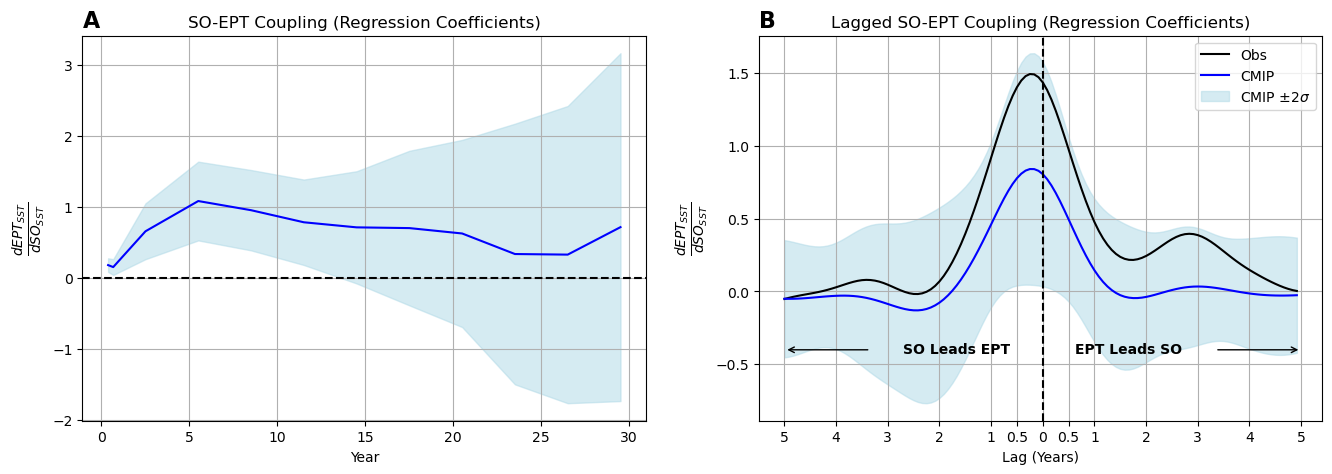

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Calculate the upper and lower bounds for shading
regs = filtered_so_ept_coupling["regs"]
regs_std = filtered_so_ept_coupling["regs_std"]
band_centers = filtered_so_ept_coupling.band_center.values

upper_bound_reg = regs.values + 1 * regs_std.values 
lower_bound_reg = regs.values - 1 * regs_std.values

# Plot rvalues_so_ept_coupling
ax1.plot(band_centers, regs.values, color='blue', label='Mean')
ax1.fill_between(band_centers, lower_bound_reg, upper_bound_reg, color='lightblue', alpha=0.5, label='2-sigma')
ax1.set_xlabel('Year')
ax1.set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
ax1.set_title(r'SO-EPT Coupling (Regression Coefficients)')
ax1.grid()
ax1.axhline(0, color='black', linestyle='--')

# Plot lag_so_ept_coupling
ax2.plot(lags, lagged_so_ept_coupling_obs["reg"].mean(dim='model'), color='black', label='Obs')
ax2.plot(lags, lagged_so_ept_coupling["reg"].mean(dim='model'), color='blue', label='CMIP')
ax2.fill_between(lags, lagged_so_ept_coupling["reg"].mean(dim='model') - 2*lagged_so_ept_coupling["reg"].std(dim='model'), lagged_so_ept_coupling["reg"].mean(dim='model') + 2*lagged_so_ept_coupling["reg"].std(dim='model'), color='lightblue', alpha=0.5, label=r'CMIP $\pm 2\sigma$')
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
ax2.set_title('Lagged SO-EPT Coupling (Regression Coefficients)')
ax2.set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
ax2.grid()

# Add text below x axis with arrows
ax2.text(-20, -0.4, "SO Leads EPT", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
ax2.annotate("", xy=(-60, -0.4), xytext=(-40, -0.4), arrowprops=dict(arrowstyle="->"))
ax2.text(20, -0.4, "EPT Leads SO", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
ax2.annotate("", xy=(60, -0.4), xytext=(40, -0.4), arrowprops=dict(arrowstyle="->"))
ax2.legend()

# Add vertical line at 0
ax2.axvline(0, color='black', linestyle='--')

ax1.set_title('A', loc="left", fontweight="bold", fontsize=16)
ax2.set_title('B', loc="left", fontweight="bold", fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3) #, wspace=0.3)

# Show the plot
#########################################################################
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_2_v2.png", dpi=300, bbox_inches="tight")
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_2_v2.pdf", dpi=300, bbox_inches="tight")

# Figure 2 - SX Correlations

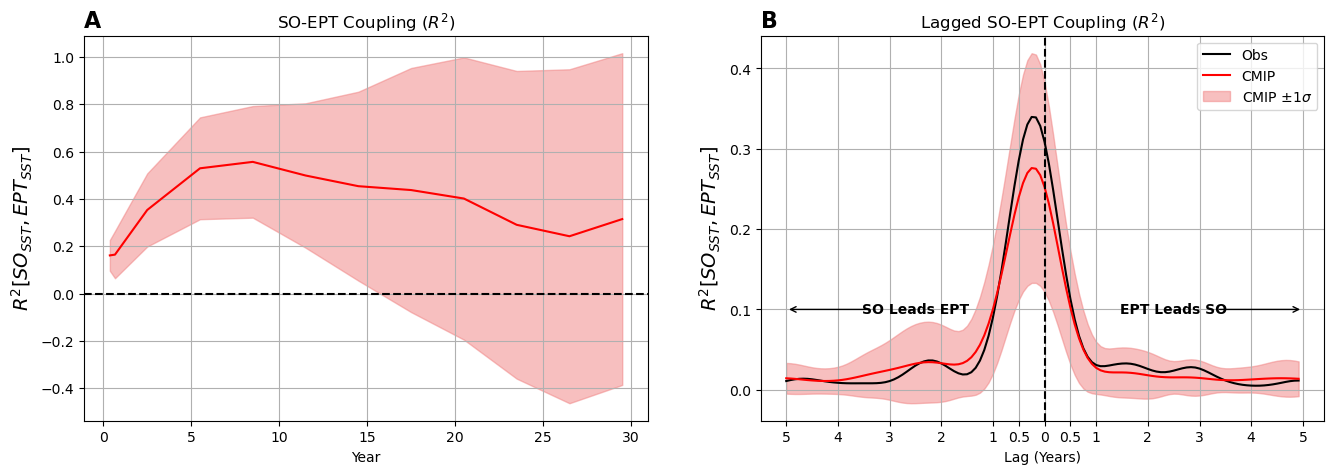

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Calculate the upper and lower bounds for shading
regs = filtered_so_ept_coupling["corrs"]
regs_std = filtered_so_ept_coupling["corrs_std"]
band_centers = filtered_so_ept_coupling.band_center.values

upper_bound_reg = regs.values + 1 * regs_std.values 
lower_bound_reg = regs.values - 1 * regs_std.values

# Plot rvalues_so_ept_coupling
ax1.plot(band_centers, regs.values, color='red', label='Mean')
ax1.fill_between(band_centers, lower_bound_reg, upper_bound_reg, color='lightcoral', alpha=0.5, label='1-sigma')
ax1.set_xlabel('Year')
ax1.set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
ax1.set_title(r'SO-EPT Coupling ($R^2$)')
ax1.grid()
ax1.axhline(0, color='black', linestyle='--')

# Plot lag_so_ept_coupling
ax2.plot(lags, (lagged_so_ept_coupling_obs["rvalues"]**2).mean(dim='model'), color='black', label='Obs')
ax2.plot(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model'), color='red', label='CMIP')
ax2.fill_between(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') - (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') + (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), color='lightcoral', alpha=0.5, label=r'CMIP $\pm 1\sigma$')
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
ax2.set_title('Lagged SO-EPT Coupling ($R^2$)')
ax2.set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
ax2.grid()


# Add text below x axis with arrows
ax2.text(-30, 0.1, "SO Leads EPT", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
ax2.annotate("", xy=(-60, 0.1), xytext=(-40, 0.1), arrowprops=dict(arrowstyle="->"))
ax2.text(30, 0.1, "EPT Leads SO", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
ax2.annotate("", xy=(60, 0.1), xytext=(40, 0.1), arrowprops=dict(arrowstyle="->"))
ax2.legend()

# Add vertical line at 0
ax2.axvline(0, color='black', linestyle='--')

ax1.set_title('A', loc="left", fontweight="bold", fontsize=16)
ax2.set_title('B', loc="left", fontweight="bold", fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3) #, wspace=0.3)

# Show the plot
#########################################################################
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_timeseries.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_timeseries.pdf", dpi=300, bbox_inches="tight")